# Scrapping the website to extract information

In [10]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "ulm.edu"
full_url = "https://ulm.edu/"

In [11]:
# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [12]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

In [15]:

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [16]:

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        
        try:
            with urllib.request.urlopen(url) as response:
                if not response.info().get('Content-Type').startswith("text/html"):
                    continue # To Escape other file formats like docs and pdfs
        except Exception as e:
            continue # 404 Errors

        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://ulm.edu/
https://ulm.edu/studenthandbook/index.html
https://ulm.edu/ulmstudents
https://ulm.edu/testingcenter
https://ulm.edu/testingcenter/gre.html
https://ulm.edu/testingcenter/placement-sat-act.html
https://ulm.edu/testingcenter/dsst.html
https://ulm.edu/testingcenter/praxis.html
https://ulm.edu/testingcenter/apc.html
https://ulm.edu/testingcenter/actsat.html
https://ulm.edu/counselingcenter/testing.html
https://ulm.edu/counselingcenter/outreach.html
https://ulm.edu/counselingcenter/schedule.html
https://ulm.edu/counselingcenter/directory.html
https://ulm.edu/counselingcenter/emergencies.html
https://ulm.edu/counselingcenter/index.html
https://ulm.edu/counselingcenter/services.html
https://ulm.edu/counselingcenter/resources.html
https://ulm.edu/testingcenter/placement.html
https://ulm.edu/testingcenter/clep.html
https://ulm.edu/testingcenter/index.html
https://ulm.edu/studentaffairs
https://ulm.edu/reslife
https://ulm.edu/registrar/ferpa.html
https://ulm.edu/registrar/topics

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [17]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [18]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/tmp/ipykernel_37480/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,s archives 2012 sept12 show.html,s archives 2012 sept12 show.html. ULM News Ar...
1,s archives 2004 oct04 queen04.html,s archives 2004 oct04 queen04.html. ULM News ...
2,s archives 2006 apr06 dance.html,s archives 2006 apr06 dance.html. ULM News Ar...
3,s archives 2008 dec08 lsbdc.html,s archives 2008 dec08 lsbdc.html. ULM News Ar...
4,s 2021 saulsberry diversity exec dir 011221 hy...,s 2021 saulsberry diversity exec dir 011221 hy...


<AxesSubplot: >

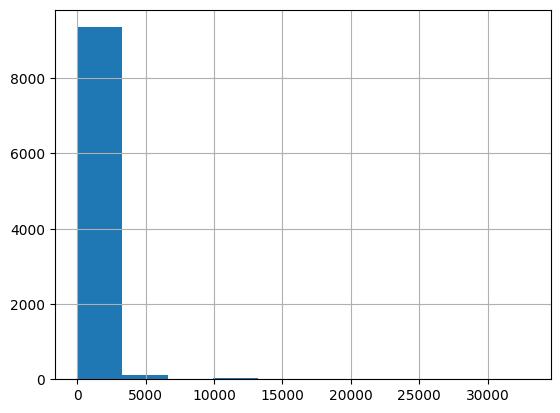

In [19]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [20]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

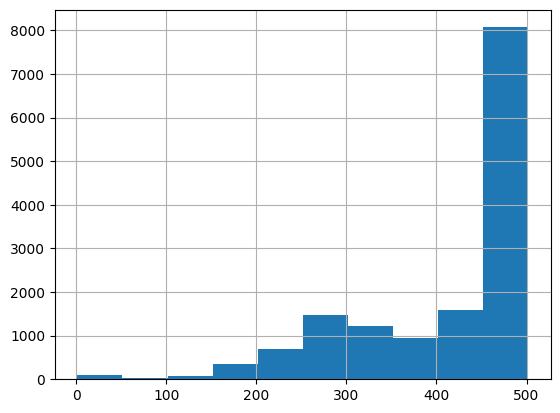

In [21]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [ ]:

# df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
# df.to_csv('processed/embeddings.csv')
# df.head()

In [23]:
import openai

openai.api_key_path=".env"

from openai.embeddings_utils import distances_from_embeddings

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,s archives 2012 sept12 show.html. ULM News Ar...,497,"[-0.0011195197002962232, -0.00845207180827856,..."
1,s archives 2004 oct04 queen04.html. ULM News ...,358,"[-0.0032124577555805445, 0.0009821420535445213..."
2,s archives 2006 apr06 dance.html. ULM News Ar...,208,"[-0.009267098270356655, -0.015563372522592545,..."
3,s archives 2008 dec08 lsbdc.html. ULM News Ar...,407,"[-0.0030397726222872734, -0.004179059993475676..."
4,s 2021 saulsberry diversity exec dir 011221 hy...,484,"[8.884824637789279e-05, 0.0037609306164085865,..."


In [38]:
print("Number of tokens:", df['n_tokens'].sum())

Number of tokens:  5970814


In [39]:
df.iloc[0,2]

array([-0.00111952, -0.00845207,  0.02155831, ...,  0.01068248,
        0.01291979, -0.02543908])

In [35]:
len(df.iloc[0,2])

1536

In [24]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,s archives 2012 sept12 show.html. ULM News Ar...,497,"[-0.0011195197002962232, -0.00845207180827856,..."
1,s archives 2004 oct04 queen04.html. ULM News ...,358,"[-0.0032124577555805445, 0.0009821420535445213..."
2,s archives 2006 apr06 dance.html. ULM News Ar...,208,"[-0.009267098270356655, -0.015563372522592545,..."
3,s archives 2008 dec08 lsbdc.html. ULM News Ar...,407,"[-0.0030397726222872734, -0.004179059993475676..."
4,s 2021 saulsberry diversity exec dir 011221 hy...,484,"[8.884824637789279e-05, 0.0037609306164085865,..."


In [25]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [26]:
answer_question(df, question="What is full form of ULM?", debug=False)

'University of Louisiana at Monroe'

In [28]:
answer_question(df, question="What is IT helpdesk phone number?")


'The IT Help Desk phone number is 318-342-3333.'

In [29]:
answer_question(df, question="When does fall enrollment begins?")


'April 20 - August 18'

In [30]:
answer_question(df, question="Should I go to ULM for computer science?")


"I don't know."

In [32]:
answer_question(df, question="What kind of scholarships are available at ULM?")


'ULM offers scholarships for incoming freshmen, transfer students, out-of-state students, international students, age sixty and over, ULM Foundation scholarships, private scholarships, ULM Talent Grants, ULM Spirit Scholarships, and federal financial aid.'

In [42]:
answer_question(df, question="What is ULM's street address?")


'3811 DeSiard Street, Monroe, LA 71209'

In [46]:
answer_question(df, question="How to connect to ULM wifi?")


'To connect to ULM wifi, you will need to have an 802.11(g/n/a/ac/ax) compliant wireless card and the SSID: ULMFaculty, ULMStudent, ULMGuest, eduroam. You will also need to set your IPV4 settings to DHCP and your login type to 802.1x. You will need to use your full email address for the user name when logging in.'

In [49]:
answer_question(df, question="How many student go to ULM?")


'9,000 students go to ULM.'

In [51]:
answer_question(df, question="Who is head of College of Business and Social Science?")


'Dr. Michelle McEacharn'

In [53]:
answer_question(df, question="Who teaches Computer Science Program?")


'Dr. Jose Cordova'

In [55]:
answer_question(df, question="Name professors of ULM?", debug=True)


Context:
s profbios.html.   Meet Your Professors | ULM University of Louisiana at Monroe    ONLINE ACADEMICS FUTURE STUDENTS STUDENTS FACULTY & STAFF ALUMNI & FRIENDS COMMUNITY  Colleges of Arts, Education,& Sciences Business &Social Sciences Health Sciences Pharmacy   Library   Graduate School Sponsored Research   Academic Affairs Academic Catalog   Continuing Education ULM Online   more... Majors & Minors Beginning Freshman Graduate Student Transfer Student International Student Online Students Continuing Education High School Programs   Apply Now Request Information Contact Us Schedule Tour Browse on the Bayou   President's Greeting   Financial Aid Scholarships   more... myULM Bookstore Financial Aid Registrar Scholarships   Student SuccessCenter Student Development Residential Life Career Development International Office   Schedule of Classes Student Handbook The Hawkeye Warhawk ID   more... Administration Faculty Senate Faculty Handbook Faculty Activities Staff Senate Textbook Ado

'John W. Sutherlin, Jeff Galle, Serpil Saydam, Kenneth Clow, Wilson Campbell, Karen Stansbury, Khalid A.El Sayed, Terry Jones, Edward ‘Gene’ Eller, and Mr.'

In [56]:
answer_question(df, question="Which majors are offered by ULM?")


'ULM offers accredited and established programs in Pharmacy and Pharmacology, Nursing, Treatment Therapy professions, Construction Services, Management Information Systems, English, Education, and more.'

In [57]:
answer_question(df, question="Where do I go to view my courses in ULM?")


'You can view your courses in ULM by going to the Schedule of Classes page in the Student Handbook.'

In [58]:
answer_question(df, question="Where can I see assignments for my classes?")


'You can refer back to the syllabus and course schedule at the beginning of each semester to see assignments for your classes.'

In [59]:
answer_question(df, question="What are partnering companies with ULM?")


"I don't know."

In [60]:
answer_question(df, question="Where can I go to eat near ULM?")


'The University of Louisiana Monroe library has opened a food market for students.'

In [61]:
answer_question(df, question="Where can I get help with my mental issues?")


'You can contact a therapist or visit the Mental Health Counseling Clinic in Room 284 of Strauss Hall at ULM. You can also reach out to The Marriage and Family Therapy Clinic at 318-342-9797. Additionally, you can contact Shayla Shaw Empowerment for Empowerment Coaching and listen to her podcast, “Navigating My Crazy”, on various platforms.'

In [62]:
answer_question(df, question="Where can I get help with my mental issues?", debug=True)


Context:
PANELIST PANELIST PANELIST Â  Â  Â  Kathryn Reppond Chief Operations Officer at Central Oil & Supply Corp Adrienne Lafrance Downtown Manager of the City of West Monroe, LA Dr. Ashanti Jones PT, DPT Â   Treat Yo' Self 2:15 pm - 3:00 pm Does your mental health and physical well-being appear at the top of your ever-growing to-do list? Women often manage the needs of others before tending to their own. The irony? We canât be nearly as helpful or productive in our personal and professional lives if we are running on half-empty. Mental health and physical health are equally important. If you had diabetes, you would seek medical intervention, right? If you are experiencing anxiety, depression, or feeling overwhelmed, you need to contact a therapist. Therapy is only one facet of self-care. Part of self-care is saying ânoâ without guilt. When someone asks you to help with a time-consuming project, itâs difficult to say âno.â However, if you are already stressed, saying ây

'You can contact a therapist or visit the Mental Health Counseling Clinic in Room 284 of Strauss Hall at ULM. You can also reach out to The Marriage and Family Therapy Clinic at 318-342-9797. Additionally, you can contact Shayla Shaw Empowerment for Empowerment Coaching and listen to her podcast, “Navigating My Crazy”, on various platforms.'